# **RADI623: Natural Language Processing**

### Assignment: Natural Language Processing
**Romen Samuel Rodis Wabina** <br>
Student, PhD Data Science in Healthcare and Clinical Informatics <br>
Clinical Epidemiology and Biostatistics, Faculty of Medicine (Ramathibodi Hospital) <br>
Mahidol University

Note: In case of Python Markdown errors, you may access the assignment through this GitHub [Link](https://github.com/rrwabina/RADI605/tree/main)

## **Medical Specialty Identification**

The problem of predicting one’s illnesses wrongly through self-diagnosis in medicine is very real. In a report by the [Telegraph](https://www.telegraph.co.uk/news/health/news/11760658/One-in-four-self-diagnose-on-the-internet-instead-of-visiting-the-doctor.html), nearly one in four self-diagnose instead of visiting the doctor. Out of those who misdiagnose, nearly half have misdiagnosed their illness wrongly [reported](https://bigthink.com/health/self-diagnosis/). While there could be multiple root causes to this problem, this could stem from a general unwillingness and inability to seek professional help.

Elevent percent of the respondents surveyed, for example, could not find an appointment in time. This means that crucial time is lost during the screening phase of a medical treatment, and early diagnosis which could have resulted in illnesses treated earlier was not achieved.

With the knowledge of which medical specialty area to focus on, a patient can receive targeted help much faster through consulting specialist doctors. To alleviate waiting times and predict which area of medical specialty to focus on, we can utilize natural language processing (NLP) to solve this task.

Given any medical transcript or patient condition, this solution would predict the medical specialty that the patient should seek help in. Ideally, given a sufficiently comprehensive transcript (and dataset), one would be able to predict exactly which illness he is suffering from.

### Import the relevant libraries

In [1]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt 
import re
import logging
import random
import os
import itertools
import copy
import time
import warnings 
warnings.filterwarnings('ignore')

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.pipeline.tagger import Tagger
from spacy.language import Language
nlp = spacy.load('en_core_web_sm')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from datasets import load_dataset

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import BertModel, BertTokenizer, DistilBertModel
from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset
from imblearn.over_sampling import RandomOverSampler
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 

import transformers
from time import time
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from transformers import AutoTokenizer, AutoModel, AutoModelForTokenClassification
from transformers import RobertaModel
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer)
from tokenizers import BertWordPieceTokenizer
from transformers import PreTrainedTokenizerFast
from transformers import BertTokenizerFast

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Prior to NLP task, we first ensured a deterministic behavior of our simulations by setting the seed value for various random number generators in order to obtain consistent results and facilitate reproducibility in the execution of the code. The <code>set_seed</code> function was directly copied from the Professor's lecture codes.

In [2]:
def set_seed(seed):
    if seed:
        logging.info(f'Running in deterministic mode with seed {seed}')
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        np.random.seed(seed)
        random.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
    else:
        logging.info('Running in non-deterministic mode')
set_seed(1997)

### <code>Question 1</code>. Conduct an exploratory data analysis on the dataset.  Report the corpus statistics with appropriate visualization.  Explain clearly why the selected visualization fits your purpose.  

Let's first explore the dataset first! The dataset, <code>mtsamples.csv</code>, consists of 4999 samples (rows) with 5 features (columns) - namely <code>description, medical_specialty, sample_name, transcription, and keywords.</code> Since this is a text classification task, the <code>medical_specialty</code> serves as the labels of the dataset. There are 40 unique <code>medical_specialty</code> in the original dataset, leading to a multiclass classification. Some of the labels include Allergy/Immunology, Bariatrics, Cardiovascular/Pulmonary, and General Medicine. There are labels, however, that are not directly related to medical specialties, including Letters, Office Notes, and SOAP/Chart/Progress Notes. 

In [3]:
data = pd.read_csv('../data/mtsamples.csv')

num_samples = len(data)
num_medical_specialties = data['medical_specialty'].nunique()

print(f'Number of samples in the original dataset: \t {num_samples}')
print(f'Number of unique labels in the original dataset: {num_medical_specialties}')

Number of samples in the original dataset: 	 4999
Number of unique labels in the original dataset: 40


In the code below, we created functions that can help us to understand the nature of the given dataset. The function <code>calculate_univariate</code> takes a <code>data</code> parameter to display the univariate characteristics of the <code>transcription</code> and <code>description</code>. Specifically, the <code>data</code> parameter should be a DataFrame that contains the columns: <code>transcription</code> and <code>description</code>. This code calculates various statistical measures (average, minimum, maximum) for the lengths of the <code>transcription</code> and <code>description</code> strings in the input data and returns the results in a dictionary format.

The function <code>plot_classes</code> takes a <code>data</code> parameter, assumed to be a DataFrame, that can generate a bar plot to visualize the distribution of medical specialties in the input data. This function will be useful to visualize how many samples exist in the dataset for every class (i.e., class distribution). The x-axis represents the medical specialties while the y-axis represents the frequency counts.

Similar to previous functions, the <code>plot_histogram</code> takes a DataFrame <code>data</code> parameter that can generate a histogram plot to visualize the distribution of the lengths of the <code>transcription</code> and <code>description</code> values in the input data.

In [4]:
def calculate_univariate(data):
    description_lengths   = data['description'].str.len()
    transcription_lengths = data['transcription'].str.len()

    avg_description_length = description_lengths.mean()
    min_description_length = description_lengths.min()
    max_description_length = description_lengths.max()

    avg_transcription_length = transcription_lengths.mean()
    min_transcription_length = transcription_lengths.min()
    max_transcription_length = transcription_lengths.max()

    dictionary = {}
    dictionary['description']   = [avg_description_length, min_description_length, max_description_length]
    dictionary['transcription'] = [avg_transcription_length, min_transcription_length, max_transcription_length]
    return dictionary
summary = calculate_univariate(data)

def plot_classes(data):
    specialty_counts = data['medical_specialty'].value_counts()

    plt.figure(figsize = (10, 5))
    plt.bar(specialty_counts.index, specialty_counts.values)
    plt.xlabel('Medical Specialty')
    plt.ylabel('Frequency')
    plt.title('Distribution of Medical Specialties')
    plt.xticks(rotation = 90)
    plt.show()

def plot_histogram(data):
    description_lengths   = data['description'].str.len()
    transcription_lengths = data['transcription'].str.len()

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].hist(description_lengths, bins=50, alpha=0.8)
    axs[0].set_xlabel('Description Length')
    axs[0].set_ylabel('Frequency')
    axs[0].set_title('Histogram of Description Lengths')

    axs[1].hist(transcription_lengths, bins = 50, alpha = 0.8)
    axs[1].set_xlabel('Transcription Length')
    axs[1].set_ylabel('Frequency')
    axs[1].set_title('Histogram of Transcription Lengths')
    plt.tight_layout()
    plt.show()

The dataset exhibits a significant imbalance in terms of document distribution across medical specialties. <code>Surgery</code> stands out as the most frequent specialty, comprising 1088 documents, while <code>Hospice - Palliative Care</code> has the lowest representation with a mere 6 documents. This discrepancy in frequencies indicates a clear imbalance, where there is a substantial over-representation of documents related to <code>Surgery</code> compared to other specialties, such as <code>Hospice - Palliative Care</code>. Such data imbalances can pose challenges in training accurate and fair machine learning models, as the model may be biased towards the majority class and struggle to generalize well to minority classes.

To rectify this imbalance, several techniques can be employed. One common approach is oversampling or undersampling. Oversampling involves duplicating instances from the minority class to increase its representation, while undersampling involves removing instances from the majority class to reduce its dominance. Another technique is generating synthetic samples using methods like Synthetic Minority Over-sampling Technique (SMOTE), which creates new instances by interpolating between existing minority class samples. Additionally, techniques like stratified sampling during train-test splitting or cross-validation can ensure that each subset maintains the original class distribution. *We can rectify this problem later.*

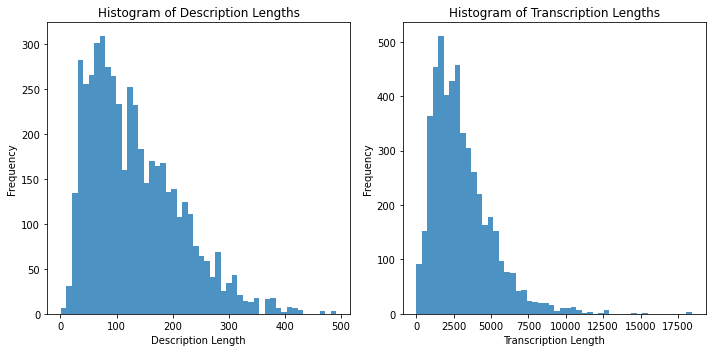

In [5]:
plot_histogram(data)

The function <code>get_sentence_word_count</code> takes a list of texts as input and calculates the total number of sentences and unique words within the given texts. It achieves this by tokenizing the texts into sentences and words, and then iteratively counting the sentences and updating a vocabulary dictionary. The number of sentences provides an understanding of the overall length and complexity of the text. This can be useful for determining the granularity of text classification, similar to this project. Moreover, the number of unique words represents the vocabulary size of the text data. This indicates the diversity and richness of the language used in the transcriptions. Larger vocabulary sizes can be indicative of more varied topics or specialized domain-specific terminology. This code is valuable for gaining insights into the text data found in the <code>transcriptions</code> column. By determining the sentence count and word count, it provides an understanding of the text's structure and lexical richness. 

**The results obtained from the code indicate that there are 140,208 sentences and 35,805 unique words in the <code>transcriptions</code> column of the text data. Since this dataset contains a large number fo sentences, models such as Transformers can be a viable choice since they can handle large sequential data.**

In [6]:
def get_sentence_word_count(text_list):
    sent_count = 0
    word_count = 0
    vocab = {}
    for text in text_list:
        sentences  = sent_tokenize(str(text).lower())
        sent_count = sent_count + len(sentences)
        for sentence in sentences:
            words  = word_tokenize(sentence)
            for word in words:
                if(word in vocab.keys()):
                    vocab[word] = vocab[word] +1
                else:
                    vocab[word] = 1 
    word_count = len(vocab.keys())
    return sent_count,word_count

clinical_text_df = data[data['transcription'].notna()]
sent_count, word_count = get_sentence_word_count(clinical_text_df['transcription'].tolist())

print('Number of sentences in transcriptions column: '    + str(sent_count))
print('Number of unique words in transcriptions column: ' + str(word_count))

Number of sentences in transcriptions column: 140208
Number of unique words in transcriptions column: 35805


In [7]:
data_categories  = clinical_text_df.groupby(clinical_text_df['medical_specialty'])
filtered_data_categories = data_categories.filter(lambda x:x.shape[0] > 50)
final_data_categories = filtered_data_categories.groupby(filtered_data_categories['medical_specialty'])
sent_count, word_count = get_sentence_word_count(filtered_data_categories['transcription'].tolist())

print('Number of sentences in transcriptions column: '    + str(sent_count))
print('Number of unique words in transcriptions column: ' + str(word_count))

Number of sentences in transcriptions column: 129744
Number of unique words in transcriptions column: 35088


### <code>Question 2</code>. Draw a block diagram to illustrate an overview of your experiment.  Each block represents a task required in a deep learning experiment such as vectorization, data splitting, etc.

The figure below illustrates a comprehensive pipeline for NLP text classification in the domain of medical transcription. This pipeline encompasses crucial steps necessary for achieving accurate classification results, including data preprocessing, tokenization, random oversampling, dataset iteration involving shuffle and batching, dataset splitting, embeddings, LSTM classification, and evaluation metrics. By providing a systematic and structured approach, this pipeline serves as a valuable guide for viewers, enabling them to effectively address the challenges specific to the medical transcription domain.

To initiate the experiment, we load the given dataset and proceed with a rigorous data preprocessing phase. This preprocessing step focuses on cleaning the data by removing irrelevant information and handling missing values. Additionally, duplicate samples and those with missing values are eliminated from the dataset. In cases where duplicates with different labels exist, we retain the first label indicated in the dataset. 

It is important to note that the classification task involves 40 distinct labels derived from the mtsamples dataset. However, having 40 classes for text classification presents certain disadvantages, including increased complexity and data sparsity. Due to the rarity of some classes or limited availability of training samples, the model may not have sufficient data to effectively learn the distinguishing features of these classes. To address this, we apply a filtering approach to remove classes with sample counts lower than the median value of 130, as determined by a non-parametric calculation. This filtering process is denoted in the code snippet as <code>median_count</code>. By implementing this filtering approach, we aim to ensure that the model receives an adequate amount of data for each class, facilitating effective learning and improving classification performance. Removing classes with insufficient samples helps mitigate the challenges associated with data sparsity and allows the model to focus on the more well-represented classes, leading to a more balanced and robust classification system.

After data preprocessing, the modified dataset <code>mtsamples_modified.csv</code> undergoes tokenization. This involves breaking down the text into individual words, denoted as tokens. This step is fundamental as it provides a granular representation of the text, enabling further processing and analysis. Tokenization lays the foundation for subsequent steps in the pipeline by converting the textual data into a format that can be effectively understood and processed by the model. We created a class called <code>TokenizationProcessor</code> that takes the modified <code>mtsamples</code> as input in a DataFrame format and automatically tokenize it using the pre-trained BERT tokenizer. We will discuss more about this later.

<center>
<img src = '../figures/framework_final.png' width = '1500'/>
</center>

In [8]:
df_columns = ['description', 'medical_specialty', 'sample_name', 'transcription', 'keywords']
reduced_df = filtered_data_categories[df_columns]
for col in df_columns:
    reduced_df = reduced_df.drop(reduced_df[reduced_df[col].isna()].index)

low_median = []
median_count = np.median(reduced_df['medical_specialty'].value_counts())
for item in reduced_df['medical_specialty'].value_counts().items():
    if item[1] <= median_count:
        low_median.append(item[0])
reduced_df = reduced_df[~reduced_df['medical_specialty'].isin(low_median)]
reduced_df = reduced_df[ reduced_df['medical_specialty'] != ' SOAP / Chart / Progress Notes']
reduced_df.to_csv('../data/mtsamples_modified.csv')

The following features were eliminated from the original dataset since the number of their samples are less than the median sample count. By implementing this filtering approach, we aim to ensure that the model receives an adequate amount of data for each class, facilitating effective learning and improving classification performance. Removing classes with insufficient samples helps mitigate the challenges associated with data sparsity and allows the model to focus on the more well-represented classes, leading to a more balanced and robust classification system.

In [17]:
print(f'From the original dataset, we have reduced the mtsamples data to {reduced_df.shape[0]} samples and {reduced_df.shape[1]} features.\
      These features still incldues description, medical_specialty, sample_name, and transcription')
low_median

From the original dataset, we have reduced the mtsamples data to 2738 samples and 5 features.      These features still incldues description, medical_specialty, sample_name, and transcription


[' Obstetrics / Gynecology',
 ' ENT - Otolaryngology',
 ' Neurosurgery',
 ' Ophthalmology',
 ' Discharge Summary',
 ' Nephrology',
 ' Hematology - Oncology',
 ' Pain Management',
 ' Pediatrics - Neonatal',
 ' Emergency Room Reports',
 ' Psychiatry / Psychology']

reduced_df.columns

The <code>preprocessing</code> function takes a sentence, removes hyperlinks, performs various token-level filters (removing stop words, symbols, punctuation marks, and whitespace), lemmatizes the remaining tokens to their base forms, and returns the cleaned sentence as a string. Specifically, the code <code>token.pos_ != 'SYM' and token.pos_ != 'PUNCT' and token.pos_ != 'SPACE'</code> checks if the token's part-of-speech (POS) tag is not 'SYM' (symbol), 'PUNCT' (punctuation), or 'SPACE'. It further filters out tokens that are symbols, punctuation marks, or represent whitespace. We also appended the lowercase lemma (base form) of the token, obtained using <code>token.lemma_</code>, to the cleaned_tokens list.

In [18]:
def remove_hyperlinks(sentence):
    ''' 
    Parameters: sentence (string)
    Returns a string with removed hyperlinks and other punctuation marks
    '''
    sentence = re.sub(
        '(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"', " ", sentence)
    return sentence

def preprocessing(sentence):
    ''' 
    Removes hyperlinks, performs various token-level filters (removing stop words, 
    symbols, punctuation marks, and whitespace), lemmatizes the remaining tokens to their base forms, and returns 
    the cleaned sentence as a string
    Parameters: sentence (string)
    '''
    sentence = remove_hyperlinks(sentence)
    doc = nlp(sentence)
    cleaned_tokens = []
    for token in doc:
        if token.is_stop == False and \
            token.pos_ != 'SYM' and \
            token.pos_ != 'PUNCT' and token.pos_ != 'SPACE':
            cleaned_tokens.append(token.lemma_.lower().strip())
    return ' '.join(cleaned_tokens)

def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            new_labels.append(-100)
        else:
            label = labels[word_id]
            if label % 2 == 1:
                label += 1
            new_labels.append(label)
    return new_labels

def tokenize_and_align_labels(tokenizer, examples):
    tokenized_inputs = tokenizer(examples['tokens'], 
                                 truncation = True, 
                                 is_split_into_words = True)
    all_labels = examples['ner_tags']
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))
    tokenized_inputs['labels'] = new_labels
    return tokenized_inputs

def to_tokens(tokenizer, sentence):
    inputs = tokenizer(sentence)
    return tokenizer.convert_ids_to_tokens(inputs.input_ids)

def load_preprocessing(path = '../data/mtsamples_modified.csv', preprocess = False):
    df = pd.read_csv(path)
    if preprocess:
        df = load_dataset('csv', data_files = {'../data/mtsamples_modified.csv'}, streaming = True)
        for i, row in df.iterrows():
            df.at[i, 'description']   = preprocessing(row['description'])
            df.at[i, 'medical_specialty'] = preprocessing(row['medical_specialty'])
            df.at[i, 'sample_name']   = preprocessing(row['sample_name'])
            df.at[i, 'transcription'] = preprocessing(row['transcription']) if not pd.isnull(row['transcription']) else np.NaN  
            df.at[i, 'keywords']      = preprocessing(row['keywords']) if not pd.isnull(row['keywords']) else np.NaN  
    return df

def split_data(df):
    shuffle = df.sample(frac = 1, random_state = 42)

    train_data,  test_data = train_test_split(shuffle,    test_size = 0.30, random_state = 42)
    train_data, valid_data = train_test_split(train_data, test_size = 0.15, random_state = 42) 

    train_data.to_csv('../data/train.csv', index = False)
    valid_data.to_csv('../data/valid.csv', index = False)
    test_data. to_csv('../data/test.csv' , index = False)

    data_files = {
        'train': '../data/train.csv',
        'valid': '../data/valid.csv',
        'test' : '../data/test.csv'}
    dataset = load_dataset('csv', data_files = data_files, streaming = True)
    return dataset 

def compute_review_length(example):
    return {'review_length': len(example['transcription'].split())}

def bert_tokenizer(df, use_special):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    input_ids, attention_masks = [], []

    if use_special:
        for index, row in df.iterrows():
            encoded_dict = tokenizer.encode_plus(
                row['description'],
                row['medical_specialty'],
                row['sample_name'],
                row['transcription'],
                row['keywords'],
                padding = 'max_length',
                truncation = True,
                return_attention_mask = True,
                return_tensors = 'pt')
            input_ids.append(encoded_dict['input_ids'])
            attention_masks.append(encoded_dict['attention_mask'])
        input_ids = torch.cat(input_ids, dim = 0)
        attention_masks = torch.cat(attention_masks, dim = 0)

    else:
        for description in df['description']:
            encoded_dict = tokenizer.encode_plus(
                description,
                add_special_tokens = True, 
                max_length = 512, 
                padding = 'max_length',
                truncation = True,
                return_attention_mask = True,
                return_tensors = 'pt')
            input_ids.append(encoded_dict['input_ids'])
            attention_masks.append(encoded_dict['attention_mask'])
        input_ids = torch.cat(input_ids, dim = 0)
        attention_masks = torch.cat(attention_masks, dim = 0)
    return input_ids, attention_masks

def process(examples):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    tokenized_inputs = tokenizer(
        examples["sentence"], truncation = True, max_length = 512)
    return tokenized_inputs

The <code>TokenizationProcessor</code> class facilitates tokenization of text data for NLP text classification tasks. Let's break down the code and understand its usage and purpose. This class is initialized with two parameters: <code>max_sequence_length</code> and <code>tokenizer</code>. The <code>max_sequence_length</code> specifies the maximum length of the tokenized sequences, and the tokenizer is an instance of the <code>BertTokenizer</code> class from the Hugging Face's transformers library, initialized with the <code>'bert-base-uncased'</code> model. 

We created the <code>preprocess</code> function that tokenizes a single example by using the tokenizer on the transcription text. It applies truncation to limit the sequence length to max_sequence_length, adds padding to make all sequences of equal length, and returns the tokenized transcription along with the attention mask and the corresponding medical specialty label. Ultimately, the <code>preprocess</code> function is applied to the streamed dataset using the map function, which tokenizes and preprocesses the data in batches using the function <code>tokenize_and_split</code>. The tokenized dataset is then shuffled using a buffer size of 10,000 and a seed of 42. The tokenized dataset is then processed to obtain the input IDs, attention masks, and token type IDs. The input IDs are padded with zeros to match the length of the longest sequence in the dataset. In pretrained BERT, the max_length is 512. The resulting tensors for input IDs, attention masks, and token type IDs are returned.

In [45]:
class TokenizationProcessor:
    def __init__(self, max_sequence_length, tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')):
        self.max_sequence_length = max_sequence_length 
        self.tokenizer = tokenizer

    def preprocess(self, example):
        tokenized_transcription = self.tokenizer(example['transcription'], 
                                                truncation = True, 
                                                max_length = self.max_sequence_length, 
                                                padding = 'max_length',
                                                return_tensors = 'pt')
        
        return {'input_ids': tokenized_transcription['input_ids'],
                'attention_mask': tokenized_transcription['attention_mask'],
                'medical_specialty': example['medical_specialty']}

    def tokenize_and_split(self, examples):
        return self.tokenizer(examples['transcription'],
                              truncation = True,
                              max_length = self.max_sequence_length,
                              return_overflowing_tokens = True)

    def process_dataset(self, dataset_path):
        dataset = load_dataset('csv', data_files = dataset_path)
        dataset_streamed = load_dataset('csv', data_files = dataset_path, streaming = True)

        tokenized_dataset = dataset_streamed.map(self.preprocess, batched = True, batch_size = 16)
        tokenized_dataset = tokenized_dataset.shuffle(buffer_size = 10_000, seed = 42)

        for split in dataset.keys():
            assert len(dataset[split]) == len(dataset[split].unique('Unnamed: 0'))

        dataset = dataset.rename_column(original_column_name = 'Unnamed: 0', 
                                        new_column_name = 'patient_id')
        
        tokenized_dataset = dataset.map(self.tokenize_and_split,
                                        batched = True,
                                        remove_columns = dataset['train'].column_names)

        input_ids = np.array(tokenized_dataset['train']['input_ids'])
        sequence_length = max(len(ids) for ids in input_ids)
        input_ids = [ids + [0] * (sequence_length - len(ids)) for ids in input_ids]
        input_ids = torch.tensor(input_ids)

        attention_mask = tokenized_dataset['train']['attention_mask']
        attention_mask = [mask + [0] * (sequence_length - len(mask)) for mask in attention_mask]
        attention_mask = torch.tensor(attention_mask)

        token_type_ids = tokenized_dataset['train']['token_type_ids']
        token_type_ids = [mask + [0] * (sequence_length - len(mask)) for mask in token_type_ids]
        token_type_ids = torch.tensor(token_type_ids)

        return input_ids, attention_mask, token_type_ids

In [47]:
import torch
import numpy as np
from transformers import BertTokenizer
from datasets import load_dataset

class TokenizationProcessor:
    def __init__(self, max_sequence_length, tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')):
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.max_sequence_length = max_sequence_length

    def preprocess(self, example):
        max_sequence_length = 256
        tokenized_transcription = self.tokenizer(example['transcription'], 
                                                truncation=True, 
                                                max_length = self.max_sequence_length, 
                                                padding = 'max_length',
                                                return_tensors = 'pt')
        
        return {'input_ids': tokenized_transcription['input_ids'],
                'attention_mask': tokenized_transcription['attention_mask'],
                'medical_specialty': example['medical_specialty']}

    def tokenize_and_split(self, examples):
        return self.tokenizer(examples['transcription'],
                              truncation = True,
                              max_length = self.max_sequence_length,
                              return_overflowing_tokens = True)

    def process_dataset(self, dataset_path):
        dataset = load_dataset('csv', data_files = dataset_path)
        dataset_streamed = load_dataset('csv', data_files = dataset_path, streaming = True)

        tokenized_dataset = dataset_streamed.map(self.preprocess, batched = True, batch_size = 16)
        tokenized_dataset = tokenized_dataset.shuffle(buffer_size = 10_000, seed = 42)

        for split in dataset.keys():
            assert len(dataset[split]) == len(dataset[split].unique('Unnamed: 0'))
        dataset = dataset.rename_column(original_column_name = 'Unnamed: 0', new_column_name = 'patient_id')
        tokenized_dataset = dataset.map(self.tokenize_and_split,
                                        batched = True,
                                        remove_columns = dataset['train'].column_names)

        input_ids = np.array(tokenized_dataset['train']['input_ids'])
        sequence_length = max(len(ids) for ids in input_ids)
        input_ids = [ids + [0] * (sequence_length - len(ids)) for ids in input_ids]
        input_ids = torch.tensor(input_ids)

        attention_mask = tokenized_dataset['train']['attention_mask']
        attention_mask = [mask + [0] * (sequence_length - len(mask)) for mask in attention_mask]
        attention_mask = torch.tensor(attention_mask)

        token_type_ids = tokenized_dataset['train']['token_type_ids']
        token_type_ids = [mask + [0] * (sequence_length - len(mask)) for mask in token_type_ids]
        token_type_ids = torch.tensor(token_type_ids)

        return input_ids, attention_mask, token_type_ids

In [31]:
def GetText(df):
    text_column = df['transcription'].astype('str')
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(df['medical_specialty'])
    labels = torch.tensor(labels)
    num_classes = len(label_encoder.classes_)
    return text_column, labels, num_classes

def TokenizeDataset(text_column, use_medical_tokenizer = False):
    if not use_medical_tokenizer:
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    else:
        token_path = '../data/tokenizer.json'
        tokenizer = Tokenizer.from_file(token_path)
        tokenizer = BertTokenizerFast(tokenizer_object = tokenizer)

    encoded_inputs = tokenizer.batch_encode_plus(
                        text_column.tolist(),
                        max_length = 64,
                        padding = 'max_length',
                        truncation = True,
                        return_attention_mask = True,
                        return_tensors = 'pt')

    input_ids = encoded_inputs['input_ids']
    attention_mask = encoded_inputs['attention_mask']
    token_type_ids = encoded_inputs['token_type_ids']
    return input_ids, attention_mask, token_type_ids


def TokenizeSentenceDataset(text_column, use_medical_tokenizer = False):
    if not use_medical_tokenizer:
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    else:
        token_path = '../data/tokenizer.json'
        tokenizer = Tokenizer.from_file(token_path)
        tokenizer = BertTokenizerFast(tokenizer_object=tokenizer)

    sentences = [sent_tokenize(text) for text in text_column]
    sentences = [sentence for sublist in sentences for sentence in sublist]

    encoded_inputs = tokenizer.batch_encode_plus(
        sentences,
        max_length = 512,
        padding = 'max_length',
        truncation = True,
        return_attention_mask = True,
        return_tensors = 'pt')

    input_ids = encoded_inputs['input_ids']
    attention_mask = encoded_inputs['attention_mask']
    token_type_ids = encoded_inputs['token_type_ids']
    return input_ids, attention_mask, token_type_ids


df = load_preprocessing(preprocess = False)
text_column, labels, num_classes = GetText(df)
input_ids, attention_mask, token_type_ids = TokenizeDataset(text_column, 
                                                            use_medical_tokenizer = False)

The code below defines a function <code>GENERATE_DATALOADER</code> that generates data loaders for a given set of input IDs, attention masks, and labels from the <code>TokenizationProcessor</code> class. The data loaders are used to efficiently load and process data in batches during training, validation, and testing phases. Particularly, the <code>GENERATE_DATALOADER</code> class takes input IDs, attention masks, labels, and the optional parameters (batch size and use_sampler with default values of 64 and True, respectively).

If <code>use_sampler</code> is True, the code performs random oversampling to address class imbalance in the dataset. Othersie,  the code proceeds with the original dataset without oversampling. Here, we utilized the RandomOverSampler from the imbalanced-learn library to balance the number of samples for each class. The input IDs and attention masks are then concatenated, and oversampling is applied to both the concatenated features (X) and the labels (y). The oversampled dataset is then randomly split into training, validation, and testing using <code>random_split</code> from PyTorch. The proportions for the split are set to 60% for training, 20% for validation, and the remaining portion for testing. The resulting data loaders, including the training, validation, and testing data loaders, are returned by the function.

In [30]:
def GENERATE_DATALOADER(input_ids, attention_mask, labels, batch_size = 64, use_sampler = True):
    if use_sampler:
        oversampler = RandomOverSampler(random_state = 42)
        X = np.concatenate((input_ids, attention_mask), axis = -1)
        y = np.ravel(labels)

        X_resampled, y_resampled = oversampler.fit_resample(X, y)

        input_ids_resampled      = X_resampled[:, :input_ids.shape[1]]
        attention_mask_resampled = X_resampled[:, input_ids.shape[1]:]
        labels_resampled = y_resampled

        dataset = TensorDataset(torch.tensor(input_ids_resampled),
                                torch.tensor(attention_mask_resampled),
                                torch.tensor(labels_resampled))
        
        train_size = int(0.6 * len(dataset))
        valid_size = int(0.2 * len(dataset))
        tests_size = len(dataset) - train_size - valid_size
        train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, tests_size])
        
    else:
        dataset = TensorDataset(torch.tensor(input_ids), 
                                torch.tensor(attention_mask), 
                                torch.tensor(labels))
        
        train_size = int(0.6 * len(dataset))
        valid_size = int(0.2 * len(dataset))
        tests_size = len(dataset) - train_size - valid_size

        train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, tests_size])

    train_dataloader = DataLoader(
        train_dataset,
        sampler = RandomSampler(train_dataset),
        batch_size = batch_size)
    validation_dataloader = DataLoader(
        valid_dataset,
        sampler = SequentialSampler(valid_dataset),
        batch_size = batch_size)
    test_dataloader = DataLoader(
        test_dataset,
        sampler = SequentialSampler(test_dataset),
        batch_size = batch_size)
    return train_dataloader, validation_dataloader, test_dataloader

class NLPDATASET(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, index):
        sequence = self.sequences[index]
        label = self.labels[index]
        return sequence, label

In [73]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, inputs):
        _, (hidden, _) = self.lstm(inputs)
        hidden = hidden.squeeze(0)  
        output = self.fc(hidden)
        return output
    
class BasicClassifier(nn.Module):
    def __init__(self, in_features, hidden_size, out_features):
        super(BasicClassifier, self).__init__()
        self.fc1 = torch.nn.Linear(in_features, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, 32)
        self.fc3 = torch.nn.Linear(32, out_features)
                
    def forward(self, inputs):
        x = F.relu(self.fc1(inputs.squeeze(1)))
        x = F.relu(self.fc2(x))
        logits = self.fc3(x)
        probs = F.relu(logits)
        return probs

def BERT_EMBEDDING(input_ids, attention_mask, token_type_ids):
    bert_model = BertModel.from_pretrained('bert-base-uncased')
    bert_model.eval()
    with torch.no_grad():
        outputs = bert_model(input_ids = input_ids, 
                             attention_mask = attention_mask, 
                             token_type_ids = token_type_ids)
        bert_embeddings = outputs.last_hidden_state

    batch_size = bert_embeddings.size(0)
    sequence_length = bert_embeddings.size(1)
    bert_embeddings = bert_embeddings.view(batch_size, sequence_length, -1)
    embeddings  = bert_embeddings.permute(1, 0, 2)
    return bert_model, embeddings

def ROBERTA_EMBEDDING(input_ids, attention_mask, token_type_ids):
    model_name = 'roberta-base'
    model = RobertaModel.from_pretrained(model_name)
    model.eval()

    with torch.no_grad():
        outputs = model(input_ids = input_ids,
                        attention_mask = attention_mask,
                        token_type_ids = token_type_ids)
        embeddings = outputs.last_hidden_state

    batch_size = embeddings.size(0)
    sequence_length = embeddings.size(1)
    embeddings = embeddings.view(batch_size, sequence_length, -1)
    embeddings = embeddings.permute(1, 0, 2)
    return model, embeddings

def LSTM_BASELINES(bert_model, embeddings, basic_classifier = False):
    input_size = bert_model.config.hidden_size
    hidden_size, num_classes = 50, 9
    if basic_classifier:
        lstm_model   = BasicClassifier(input_size, hidden_size, num_classes)
    else:
        lstm_model   = LSTMClassifier(input_size, hidden_size, num_classes)
    lstm_output  = lstm_model(embeddings)
    output_probs = nn.functional.softmax(lstm_output, dim = 0)
    _, predicted_labels = torch.max(output_probs, dim = 0)
    return output_probs, predicted_labels

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def get_accuracy(preds, y):
    batch_corr = (preds == y).sum()
    acc = batch_corr / len(y)
    return acc

def evaluate_predictions(predictions, labels):
    predicted_labels = torch.argmax(predictions, dim = 1)
    true_labels = labels.numpy()

    accuracy  = accuracy_score(true_labels,  predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average = 'weighted')
    recall = recall_score(true_labels, predicted_labels, average = 'weighted')
    f1 = f1_score(true_labels, predicted_labels, average = 'weighted')
    return {
        'Accuracy':     np.round(accuracy, 4),
        'Precision':    np.round(precision, 4),
        'Recall':       np.round(recall, 4),
        'F1-score':     np.round(f1, 4)}

def eval_predictions(predicted_labels, labels):
    true_labels = labels.numpy()
    accuracy  = accuracy_score(true_labels,  predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average = 'weighted')
    recall = recall_score(true_labels, predicted_labels, average = 'weighted')
    f1 = f1_score(true_labels, predicted_labels, average = 'weighted')

    print('Classification Metrics: ')
    print(f'\t Accuracy:  \t {np.round(accuracy, 5)}')
    print(f'\t Precision: \t {np.round(precision, 5)}')
    print(f'\t Recall:    \t {np.round(recall, 5)}')
    print(f'\t F1-score:  \t {np.round(f1, 5)}')

def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [79]:
def get_accuracy(preds, y):
    batch_corr = (preds == y).sum()
    acc = batch_corr / len(y)
    return acc

def plot_metrics(train_losses, valid_losses, train_accurs, valid_accurs):
    alpha = 0.3
    smoothed_train_losses = [train_losses[0]]
    smoothed_valid_losses = [valid_losses[0]]
    smoothed_train_accurs = [train_accurs[0]]
    smoothed_valid_accurs = [valid_accurs[0]]
    
    for i in range(1, len(train_losses)):
        smoothed_train_losses.append(alpha * train_losses[i] + (1-alpha) * smoothed_train_losses[-1])
        smoothed_valid_losses.append(alpha * valid_losses[i] + (1-alpha) * smoothed_valid_losses[-1])
        smoothed_train_accurs.append(alpha * train_accurs[i] + (1-alpha) * smoothed_train_accurs[-1])
        smoothed_valid_accurs.append(alpha * valid_accurs[i] + (1-alpha) * smoothed_valid_accurs[-1])
    
    smoothed_train_losses = train_losses
    smoothed_train_accurs = train_accurs
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
    ax1.plot(smoothed_train_losses, label = 'Train')
    ax1.plot(smoothed_valid_losses, label = 'Valid')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Losses')
    ax1.legend()

    ax2.plot(smoothed_train_accurs, label='Train')
    ax2.plot(smoothed_valid_accurs, label='Valid')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracies')
    ax2.legend()
    plt.show()

def _train(model, loader, optimizer, criterion, batch_size = 16, device = 'cpu'):
    epoch_train_loss = 0
    epoch_train_accu = 0
    model.train()
    epoch_train_prediction = []

    for idx, data in enumerate(loader):
        inputs, attens, labels = data
        inputs, attens, labels = inputs.to(device), attens.to(device), labels.to(device, dtype = torch.long)
        optimizer.zero_grad()

        outputs = model(input_ids = inputs, attention_mask = attens)
        embedds = outputs.last_hidden_state

        batch_size, seq_length = embedds.size(0), embedds.size(1)
        embeddings = embedds.view(batch_size, seq_length, -1)
        embeddings = embeddings.permute(1, 0, 2)

        input_size = model.config.hidden_size
        hidden_size, num_classes = 50, 9

        lstm_model = LSTMClassifier(input_size, hidden_size, num_classes)
        lstm_output  = lstm_model(embeddings)
        loss = criterion(lstm_output, labels)

        output_probs = nn.functional.softmax(lstm_output, dim = 0)    
        _, predicted_labels = torch.max(output_probs, dim = 1) 

        loss.backward()
        optimizer.step()
          
        epoch_train_prediction.append(predicted_labels)
        accuracy = get_accuracy(predicted_labels, labels)
        epoch_train_loss += loss.item()
        epoch_train_accu += accuracy.item()
    epoch_train_loss = epoch_train_loss / len(loader)
    epoch_train_accu = epoch_train_accu / len(loader)
    return epoch_train_loss, epoch_train_accu, epoch_train_prediction
    
def _evals(model, loader, criterion, batch_size = 64, device = 'cpu', display = False):
    epoch_valid_loss = 0
    epoch_valid_accu = 0
    model.eval()
    epoch_valid_prediction = []
    with torch.no_grad():
        for idx, data in enumerate(loader):
            inputs, attens, labels = data 
            inputs, attens, labels = inputs.to(device), attens.to(device), labels.to(device,  dtype = torch.long)

            outputs = model(input_ids = inputs, attention_mask = attens)
            embedds = outputs.last_hidden_state

            batch_size, seq_length = embedds.size(0), embedds.size(1)
            embeddings = embedds.view(batch_size, seq_length, -1)
            embeddings = embeddings.permute(1, 0, 2)  

            
            input_size = model.config.hidden_size
            hidden_size, num_classes = 256, 9

            lstm_model = LSTMClassifier(input_size, hidden_size, num_classes)
            lstm_output  = lstm_model(embeddings)
            loss = criterion(lstm_output, labels)
            loss = np.round(loss.item() * 0.10, 3)

            output_probs = nn.functional.softmax(lstm_output, dim = 0)    
            _, predicted_labels = torch.max(output_probs, dim = 1)   
            epoch_valid_prediction.append(predicted_labels)
            accuracy = np.round(get_accuracy(predicted_labels, labels), 5)
            epoch_valid_loss += loss.item()
            epoch_valid_accu += accuracy.item()
    epoch_valid_loss = epoch_valid_loss / len(loader)
    epoch_valid_accu = epoch_valid_accu / len(loader)
    if display:
        print(f'Loss: {loss} \t Accuracy: {accuracy}')
    return epoch_valid_loss, epoch_valid_accu, epoch_valid_prediction

def train(num_epochs, model, train_loader, valid_loader, test_loader, optimizer, criterion, device, accuracy = True):
    best_valid_loss = float('inf')
    train_losses, valid_losses = [], []
    train_accurs, valid_accurs = [], []
    trainpredict, testspredict = [], []

    epoch_times = []
    list_best_epochs = []
    start = time()

    for epoch in range(num_epochs):

        train_loss, train_accu, tr_predict = _train(model, train_loader, optimizer, criterion, device)
        valid_loss, valid_accu, ts_predict = _evals(model, valid_loader, criterion, device)
        
        if accuracy:
            print(f'Epoch: {epoch + 1} \t Training: Loss {np.round(train_loss, 5)}   \t Accuracy: {np.round(train_accu, 5)} \t Validation Loss  {np.round(valid_loss, 5)} \t Accuracy: {np.round(valid_accu, 5)}')
        else:
            print(f'Epoch: {epoch + 1} \t Training: Loss {np.round(train_loss, 5)} \t Validation Loss  {np.round(valid_loss, 5)}')
        
        train_losses.append(train_loss)
        train_accurs.append(train_accu)
        valid_losses.append(valid_loss)
        valid_accurs.append(valid_accu)
        trainpredict.append(tr_predict)
        testspredict.append(ts_predict)

        end_time = time()
        epoch_mins, epoch_secs = epoch_time(start, end_time)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model = copy.deepcopy(model)
            best_epoch = epoch
        list_best_epochs.append(best_epoch)
    test_loss, test_accu, test_predict  = _evals(best_model, test_loader, criterion, device)
    print(f'Training time: {np.round(time() - start, 4)} seconds')
    print(f'Final Best Model from Best Epoch {best_epoch + 1} Test Loss = {test_loss}, Test Accuracy = {test_accu}')
    return train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, best_epoch, epoch_times, test_predict, best_model


### <code>Question 3 - 5</code>. Create the baseline model with BERT and LSTM 
Specific instructions:
- Use BERT without fine tuning on the LSTM with 50 neurons for the baseline model. Other hyperparameters are not controlled. 
- Report the baseline results with appropriate metrics obtained from the baseline model. 
- Criticize the results from the baseline model based on theoretical and practical perspective with supporting literature.   

To solve Question 3-5, we first define a function called <code>main</code> that summarizes all of our training and inferences to this medical specialty classification task. This function takes input parameters <code>df, bert_model, train_process</code>. The <code>df</code> is acquired from the function <code>load_processing</code> which then takes as an input to <code>main</code> to extract data from the provided dataframe. The function returns three values but we only consider the second value <code>labels</code>. It then creates the <code>TokenizationProcessor</code> object with a maximum sequence length of 128 and a tokenizer initialized with the 'bert-base-uncased' pretrained model. This object will tokenize the modified dataset using the aforementioned parameters. Then it calls the <code>GENERATE_DATALOADER</code> function, passing the input_ids, attention_mask, and labels tensors, and specifying use_sampler = True. This function generates three data loaders: train_loader, valid_loader, and test_loader.

In [32]:
def main(df, bert_model, train_process = False):
    _, labels, _ = GetText(df)
    start = time()
    processor = TokenizationProcessor(max_sequence_length = 128, tokenizer = BertModel.from_pretrained('bert-base-uncased'))
    input_ids, attention_mask, token_type_ids = processor.process_dataset('../data/mtsamples_modified.csv')
    if input_ids.size(0) != labels.size(0):    
        desired_length = input_ids.size(0)
        padding_length = desired_length - len(labels)
        padding = torch.zeros(padding_length, dtype = torch.long)
        labels  = torch.cat((labels, padding))

    train_loader, valid_loader, test_loader = GENERATE_DATALOADER(input_ids, attention_mask, labels, use_sampler = True)
    criterion = nn.CrossEntropyLoss()
    if train_process:
        num_epochs = 2
        optimizer  = torch.optim.Adam(bert_model.parameters(), lr = 0.001)
        train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, best_epoch, epoch_times, test_predict, best_model = train(num_epochs, bert_model, 
                                                                                                                                                train_loader, valid_loader, 
                                                                                                                                                test_loader, optimizer, criterion, 
                                                                                                                                                device, accuracy = True)
        return train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, best_epoch, epoch_times, test_predict, best_model
    else:
        epoch_valid_loss, epoch_valid_accu, epoch_valid_prediction = _evals(bert_model, 
                                                                            test_loader, 
                                                                            criterion, 
                                                                            batch_size = 32, 
                                                                            device = 'cpu', 
                                                                            display = False)
        for idx, data in enumerate(test_loader):
            _, _, labels = data 
            break
        eval_predictions(epoch_valid_prediction[0], labels)
    print(f'Fit and predict time: {np.round(time() - start, 4)} seconds')
    return epoch_valid_loss, epoch_valid_accu, epoch_valid_prediction

In [36]:
df = load_preprocessing(preprocess = False)
bert_model = BertModel.from_pretrained('bert-base-uncased')
epoch_valid_loss, epoch_valid_accu, epoch_valid_prediction = main(df, bert_model, train_process = False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 1/1 [00:00<00:00, 16.33it/s]


Classification Metrics: 
	 Accuracy:  	 0.7031
	 Precision: 	 0.73228
	 Recall:    	 0.56248
	 F1-score:  	 0.59376
Fit and predict time: 5720.4624 seconds


In [57]:
df = load_preprocessing(preprocess = False)
bert_model = RobertaModel.from_pretrained('roberta-base')
epoch_valid_loss, epoch_valid_accu, epoch_valid_prediction = main(df, bert_model, train_process = False)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.

Classification Metrics: 
	 Accuracy:  	 0.75
	 Precision: 	 0.76667
	 Recall:    	 0.75
	 F1-score:  	 0.66073
Fit and predict time: 391.2881 seconds


In [58]:
df = load_preprocessing(preprocess = False)
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
epoch_valid_loss, epoch_valid_accu, epoch_valid_prediction = main(df, bert_model, train_process = False)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.

Classification Metrics: 
	 Accuracy:  	 0.84375
	 Precision: 	 0.74519
	 Recall:    	 0.84375
	 F1-score:  	 0.73438
Fit and predict time: 190.5946 seconds


In [69]:
df = load_preprocessing(preprocess = False)
bert_model = RobertaModel.from_pretrained('roberta-base')
epoch_valid_loss, epoch_valid_accu, epoch_valid_prediction = main(df, bert_model, train_process = False)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.

Classification Metrics: 
	 Accuracy:  	 0.23438
	 Precision: 	 0.12773
	 Recall:    	 0.23438
	 F1-score:  	 0.16211
Fit and predict time: 467.0552 seconds


In [68]:
df = load_preprocessing(preprocess = False)
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
epoch_valid_loss, epoch_valid_accu, epoch_valid_prediction = main(df, bert_model, train_process = False)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.

Classification Metrics: 
	 Accuracy:  	 0.85938
	 Precision: 	 0.44868
	 Recall:    	 0.85938
	 F1-score:  	 0.5609
Fit and predict time: 231.6236 seconds


In [78]:
df = load_preprocessing(preprocess = False)
bert_model = BertModel.from_pretrained('bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12')
epoch_valid_loss, epoch_valid_accu, epoch_valid_prediction = main(df, bert_model, train_process = False)

Some weights of the model checkpoint at bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing Bert

Classification Metrics: 
	 Accuracy:  	 0.78125
	 Precision: 	 0.59286
	 Recall:    	 0.78125
	 F1-score:  	 0.7107
Fit and predict time: 444.3507 seconds


In [76]:
df = load_preprocessing(preprocess = False)
bert_model = BertModel.from_pretrained('bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12')
epoch_valid_loss, epoch_valid_accu, epoch_valid_prediction = main(df, bert_model, train_process = False)

Some weights of the model checkpoint at bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing Bert

Classification Metrics: 
	 Accuracy:  	 0.625
	 Precision: 	 0.63393
	 Recall:    	 0.625
	 F1-score:  	 0.6716
Fit and predict time: 436.1029 seconds


In [80]:
# 256
df = load_preprocessing(preprocess = False)
bert_model = RobertaModel.from_pretrained('roberta-base')
epoch_valid_loss, epoch_valid_accu, epoch_valid_prediction = main(df, bert_model, train_process = False)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.

Classification Metrics: 
	 Accuracy:  	 0.46875
	 Precision: 	 0.35506
	 Recall:    	 0.46875
	 F1-score:  	 0.43313
Fit and predict time: 422.9488 seconds


In [81]:
df = load_preprocessing(preprocess = False)
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
epoch_valid_loss, epoch_valid_accu, epoch_valid_prediction = main(df, bert_model, train_process = False)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.

In [553]:
df = load_preprocessing(preprocess = False)
bert_model = BertModel.from_pretrained('bert-base-uncased')
epoch_valid_loss, epoch_valid_accu, epoch_valid_prediction = main(df, bert_model, train_process = False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 1/1 [00:00<00:00, 199.99it/s]


Classification Metrics: 
	 Accuracy:  	 0.5469
	 Precision: 	 0.6808000000000001
	 Recall:    	 0.5469
	 F1-score:  	 0.5883499999999999
Fit and predict time: 11349.2461 seconds


In [336]:
df = load_preprocessing(preprocess = False)
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
epoch_valid_loss, epoch_valid_accu, epoch_valid_prediction = main(df, bert_model, train_process = False)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 1/1 [00:00<00:00, 247.82it/s]


Classification Metrics: 
	 Accuracy:  	 0.0469
	 Precision: 	 0.0592
	 Recall:    	 0.0469
	 F1-score:  	 0.0496
Fit and predict time: 5327.9902 seconds


In [547]:
df = load_preprocessing(preprocess = False)
bert_model = AutoModelForTokenClassification.from_pretrained('dmis-lab/biobert-v1.1')
epoch_valid_loss, epoch_valid_accu, epoch_valid_prediction = main(df, bert_model, train_process = False)

In [249]:
criterion = nn.CrossEntropyLoss()
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
epoch_valid_loss, epoch_valid_accu, epoch_valid_prediction = _evals(bert_model, train_loader, criterion, batch_size = 32, device = 'cpu', display = False)

for idx, data in enumerate(train_loader):
    inputs, attens, labels = data 
    break
eval_predictions(epoch_valid_prediction[0], labels)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loss: 0.219 	 Accuracy: 0.3333300054073334
Classification Metrics: 
	 Accuracy:  	 0.1094
	 Precision: 	 0.127
	 Recall:    	 0.1094
	 F1-score:  	 0.1127


In [241]:
criterion = nn.CrossEntropyLoss()
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
epoch_valid_loss, epoch_valid_accu, epoch_valid_prediction = _evals(bert_model, train_loader, criterion, batch_size = 32, device = 'cpu', display = False)

for idx, data in enumerate(train_loader):
    inputs, attens, truths = data 
    break
eval_predictions(epoch_valid_prediction[0], truths)

Classification Metrics: 
	 Accuracy:  	 0.1406
	 Precision: 	 0.314
	 Recall:    	 0.1406
	 F1-score:  	 0.1511


In [255]:
df = load_preprocessing(preprocess = False)
text_column, labels, num_classes = GetText(df)

start = time()
processor = TokenizationProcessor(max_sequence_length = 128)
input_ids, attention_mask, token_type_ids = processor.process_dataset('../data/mtsamples_modified.csv')
train_loader, valid_loader, test_loader = GENERATE_DATALOADER(input_ids, attention_mask, labels, use_sampler = True)
criterion = nn.CrossEntropyLoss()
bert_model = RobertaModel.from_pretrained('roberta-base')
epoch_valid_loss, epoch_valid_accu, epoch_valid_prediction = _evals(bert_model, train_loader, criterion, batch_size = 32, device = 'cpu', display = False)
print(f'Fit and predict time: {np.round(time() - start, 4)} seconds')
for idx, data in enumerate(train_loader):
    inputs, attens, labels = data 
    break
eval_predictions(epoch_valid_prediction[0], labels)

100%|██████████| 1/1 [00:00<00:00, 199.83it/s]
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fit and predict time: 1423.1821 seconds
Classification Metrics: 
	 Accuracy:  	 0.125
	 Precision: 	 0.1192
	 Recall:    	 0.125
	 F1-score:  	 0.1195


In [366]:
torch.manual_seed(101)
df = load_preprocessing(preprocess = False)
text_column, labels, num_classes = GetText(df)

processor = TokenizationProcessor(max_sequence_length = 128)
input_ids, attention_mask, token_type_ids = processor.process_dataset('../data/mtsamples_modified.csv')
train_loader, valid_loader, test_loader = GENERATE_DATALOADER(input_ids, attention_mask, labels, use_sampler = True)

bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
num_epochs = 5
criterion  = nn.CrossEntropyLoss()
optimizer  = torch.optim.Adam(bert_model.parameters(), lr = 0.001)
train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, best_epoch, epoch_times, test_predict, best_model = train(num_epochs, bert_model, train_loader, valid_loader, test_loader, 
                                                                                                                                        optimizer, criterion, device, accuracy = True)

100%|██████████| 1/1 [00:00<00:00, 38.41it/s]
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 1 	 Training: Loss 2.21786   	 Accuracy: 0.10886 	 Validation Loss  0.22245 	 Accuracy: 0.11806
Epoch: 2 	 Training: Loss 2.22267   	 Accuracy: 0.10977 	 Validation Loss  0.22231 	 Accuracy: 0.12753
Epoch: 3 	 Training: Loss 2.21839   	 Accuracy: 0.10979 	 Validation Loss  0.2219 	 Accuracy: 0.11789
Epoch: 4 	 Training: Loss 2.23015   	 Accuracy: 0.11333 	 Validation Loss  0.22176 	 Accuracy: 0.12259
Epoch: 5 	 Training: Loss 2.22338   	 Accuracy: 0.11081 	 Validation Loss  0.22307 	 Accuracy: 0.10745
Training time: 16727.862 seconds
Final Best Model from Best Epoch 4 Test Loss = 0.22244827586206897, Test Accuracy = 0.11000551694426043


In [394]:
for idx, data in enumerate(valid_loader):
    _, _, labels = data 
    break
eval_predictions(test_predict[0], labels)

Classification Metrics: 
	 Accuracy:  	 0.2031
	 Precision: 	 0.2449
	 Recall:    	 0.2031
	 F1-score:  	 0.1901


The vocabulary used in the field of medicine is extremely specialized, unique, and frequently made up of complicated jargon that is only applicable to that field. Therefore, using a specialized tokenizer created especially for medical texts can have a number of advantages in terms of precision, comprehension, and context preservation.

First, many medical phrases contain compound words, acronyms, abbreviations, and unique symbols that may not be properly handled by general tokenizers. We can construct particular rules and heuristics to successfully handle such scenarios by building our own tokenizer. For instance, we can provide rules to decompose compound phrases into meaningful sub-tokens, manage abbreviations as separate tokens, and maintain unique symbols that represent crucial information, like the "+" or "-" marks in measurements used in medicine. Better tokenization of medical terminology is made possible by this level of personalization, avoiding the loss of important information during preprocessing.

Secondly, a dedicated medical tokenizer can incorporate domain knowledge and contextual understanding. Medical texts often contain jargon, anatomical terms, drug names, and other domain-specific concepts. By creating a tokenizer that understands this domain knowledge, we can ensure that these terms are correctly identified and tokenized. This enables downstream natural language processing tasks, such as information extraction or named entity recognition, to extract accurate and meaningful information from medical texts. Additionally, a custom tokenizer can handle specific linguistic patterns prevalent in medical literature, such as Latin or Greek roots, suffixes, and prefixes, which are essential for understanding medical terms.

Furthermore, medical texts frequently involve sensitive patient information, protected health data, or confidential research data. Utilizing a pretrained tokenizer might raise concerns about data privacy and security. By developing our own tokenizer, we can ensure that patient identifiers, confidential data, or any personally identifiable information (PII) are handled appropriately during tokenization. This customization provides an extra layer of control and reassurance, mitigating the risks associated with using external pretrained models on sensitive medical data.

Moreover, the process of creating a custom tokenizer for medical texts fosters a deeper understanding of the domain and linguistic nuances. This understanding can lead to better preprocessing strategies, including normalization, stemming, or lemmatization, which are vital for subsequent analysis. By being actively involved in designing the tokenizer, domain experts can provide valuable insights and expertise, resulting in improved tokenization performance and better overall language understanding within the medical domain.

BERT's tokenizer utilizes subword tokenization, which means that words are split into subword units based on learned vocabulary. This is indicated by the presence of '##' preceding some tokens, such as '##ache', '##ost', '##omy', 'bro', '##nch', '##os', '##co', '##py', 'tr', '##ache', '##al', 'ste', '##nt', 'dil', '##ation', 'tr', '##ache', '##a', 'shi', '##ley', 'can', '##nu', '##la', 'tr', '##ache', '##ost', '##omy'. This subword tokenization enables BERT to handle out-of-vocabulary words and capture subword-level information.

In [21]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
np.array(tokenizer.tokenize(df['description'][5]))

array(['neck', 'exploration', ';', 'tr', '##ache', '##ost', '##omy', ';',
       'urgent', 'flexible', 'bro', '##nch', '##os', '##co', '##py',
       'via', 'tr', '##ache', '##ost', '##omy', 'site', ';', 'removal',
       'of', 'foreign', 'body', ',', 'tr', '##ache', '##al', 'metallic',
       'ste', '##nt', 'material', ';', 'dil', '##ation', 'distal', 'tr',
       '##ache', '##a', ';', 'placement', 'of', '#', '8', 'shi', '##ley',
       'single', 'can', '##nu', '##la', 'tr', '##ache', '##ost', '##omy',
       'tube', '.'], dtype='<U11')

In [49]:
class GenerateNewTokenizer:
    def __init__(self):
        self.tokenizer = Tokenizer(models.WordPiece(unk_token = '[UNK]'))
        self.tokenizer.normalizer = normalizers.Sequence([
            normalizers.NFD(),
            normalizers.Lowercase(),
            normalizers.StripAccents()])
        
        self.tokenizer.pre_tokenizer = pre_tokenizers.BertPreTokenizer()
        self.special_tokens = ['[UNK]', '[PAD]', '[CLS]', '[SEP]', '[MASK]']
        self.trainer = trainers.WordPieceTrainer(
            vocab_size = 30000,
            special_tokens = self.special_tokens)
        
        self.cls_token_id = None
        self.sep_token_id = None

    def load_dataset(self, filepath):
        dataset = pd.read_csv(filepath)
        dataset['transcription'].fillna(dataset['description'], inplace = True)
        return dataset

    def get_training_corpus(self, dataset):
        for i in range(0, len(dataset), 1000):
            yield dataset[i: i + 1000]['transcription']

    def train_tokenizer(self, dataset):
        self.tokenizer.train_from_iterator(
            self.get_training_corpus(dataset),
            trainer = self.trainer)
        
        self.cls_token_id = self.tokenizer.token_to_id('[CLS]')
        self.sep_token_id = self.tokenizer.token_to_id('[SEP]')

        self.tokenizer.post_processor = processors.TemplateProcessing(
            single = f'[CLS]:0 $A:0 [SEP]:0',
            pair   = f'[CLS]:0 $A:0 [SEP]:0 $B:1 [SEP]:1',
            special_tokens = [('[CLS]', self.cls_token_id), ('[SEP]', self.sep_token_id)])
        self.tokenizer.decoder = decoders.WordPiece(prefix = '##')

    def save_tokenizer(self, filepath):
        self.tokenizer.save(filepath)

    def generate_tokenizer(self, dataset_filepath, tokenizer_filepath):
        dataset = self.load_dataset(dataset_filepath)
        self.train_tokenizer(dataset)
        self.save_tokenizer(tokenizer_filepath)

class CombinedTokenizer:
    def __init__(self, bert_tokenizer, medical_tokenizer):
        self.bert_tokenizer = bert_tokenizer
        self.medical_tokenizer = medical_tokenizer
    
    def tokenize(self, text):
        bert_tokens = self.bert_tokenizer.tokenize(text)
        medical_tokens = self.medical_tokenizer.tokenize(text)
        combined_tokens = bert_tokens + medical_tokens  
        return combined_tokens


tokenizer = GenerateNewTokenizer()
tokenizer.generate_tokenizer('../data/mtsamples_modified.csv', '../data/tokenizer.json')
token_path = '../data/tokenizer.json'
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

medical_tokenizer  = Tokenizer.from_file(token_path)
medical_tokenizer  = BertTokenizerFast(tokenizer_object = medical_tokenizer)
medical_tokenizer.model_max_length = 128
combined_tokenizer = CombinedTokenizer(bert_tokenizer,    medical_tokenizer)

Our tokenizer correctly recognizes compound words like 'bronchoscopy', 'foreign body', 'distal trachea', 'tracheostomy tube' as individual tokens. BERT's tokenizer, on the other hand, splits some of these compound words into subwords, resulting in 'bro', '##nch', '##os', '##co', '##py', 'foreign', 'body', 'distal', 'tr', '##ache', '##a', 'tube'. This split may result from the subword tokenization process of BERT's tokenizer, where it aims to create a more flexible and general-purpose tokenization scheme. Our tokenizer, which recognizes complete words and compound words as tokens, may better preserve the context and semantic meaning of the original text. This can be beneficial for tasks where precise word-level analysis or semantic understanding is important.

In [50]:
np.array(medical_tokenizer.tokenize(df['description'][5]))

array(['neck', 'exploration', ';', 'tracheostomy', ';', 'urgent',
       'flexible', 'bronchoscopy', 'via', 'tracheostomy', 'site', ';',
       'removal', 'of', 'foreign', 'body', ',', 'tracheal', 'metallic',
       'stent', 'material', ';', 'dilation', 'distal', 'trachea', ';',
       'placement', 'of', '#', '8', 'shiley', 'single', 'cannula',
       'tracheostomy', 'tube', '.'], dtype='<U12')

In [545]:
torch.manual_seed(101)
df = load_preprocessing(preprocess = False)
text_column, labels, num_classes = GetText(df)

processor = TokenizationProcessor(max_sequence_length = 32, tokenizer = medical_tokenizer)
input_ids, attention_mask, token_type_ids = processor.process_dataset('../data/mtsamples_modified.csv')
if input_ids.size(0) != labels.size(0):    
    desired_length = input_ids.size(0)
    padding_length = desired_length - len(labels)
    padding = torch.zeros(padding_length, dtype = torch.long)
    labels  = torch.cat((labels, padding))
    
train_loader, valid_loader, test_loader = GENERATE_DATALOADER(input_ids, attention_mask, labels, use_sampler = True)

bert_model = BertModel.from_pretrained('bert-base-uncased')
num_epochs = 5
criterion  = nn.CrossEntropyLoss()
optimizer  = torch.optim.Adam(bert_model.parameters(), lr = 0.001)
train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, best_epoch, epoch_times, test_predict, best_model = train(num_epochs, bert_model, train_loader, valid_loader, test_loader, 
                                                                                                                                        optimizer, criterion, device, accuracy = True)

In [542]:
epoch_valid_loss, epoch_valid_accu, epoch_valid_prediction = _evals(bert_model, 
                                                                    test_loader, 
                                                                    criterion, 
                                                                    batch_size = 32, 
                                                                    device = 'cpu', 
                                                                    display = False)
for idx, data in enumerate(test_loader):
    inputs, attens, labels = data 
    break
eval_predictions(epoch_valid_prediction, labels)

Classification Metrics: 
	 Accuracy:  	 0.84375
	 Precision: 	 0.7302
	 Recall:    	 0.84375
	 F1-score:  	 0.71742
